# Minerva: AI Guardian for Scam Protection

This notebook implements a multi-agent system for analyzing images (screenshots) to identify scam attempts, and provide personalized scam prevention. It uses [AutoGen](https://github.com/microsoft/autogen/) to orchestrate various specialized agents that work together.

Benefits:
- Automates the process of identifying suspicious scam patterns.
- Prevents Financial Loss
- Saves Time: Early scam detection reduces the number of claims filed by end-users.

### Install Dependencies

In [1]:
%pip install -q autogen-agentchat==0.4.0.dev11 autogen-ext[openai]==0.4.0.dev11 pillow pytesseract pyyaml 

Note: you may need to restart the kernel to use updated packages.


### Model Initialization

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient

load_dotenv(find_dotenv())

model = OpenAIChatCompletionClient(
    model="gpt-4o",
    api_key=os.getenv("OPENAI_API_KEY")
)

### Tools Creation

In [3]:
from autogen_core.tools import FunctionTool
from tools import Tools

tools = Tools()

ocr_tool = FunctionTool(
    tools.ocr, description="Extracts text from an image path"
)

url_checker_tool = FunctionTool(
    tools.is_url_safe, description="Checks if a URL is safe"
)

### Agents Creation

In [4]:
import yaml

with open('config/agents.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [5]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import RoundRobinGroupChat

ocr_agent = AssistantAgent(
    name="OCR_Specialist",
    description="Extracts text from an image",
    system_message=config['ocr_agent']['assignment'],
    model_client=model,
    tools=[ocr_tool]
)

content_agent = AssistantAgent(
    name="Content_Analyst",
    description="Analyzes the text for scam patterns",
    system_message=config['content_agent']['assignment'],
    model_client=model,
    tools=[url_checker_tool]
)

decision_agent = AssistantAgent(
    name="Decision_Maker",
    description="Synthesizes the analyses and make final determination",
    system_message=config['decision_agent']['assignment'],
    model_client=model
)

summary_agent = AssistantAgent(
    name="Summary_Agent",
    description="Generate a summary of the final determination",
    system_message=config['summary_agent']['assignment'],
    model_client=model
)

language_translation_agent = AssistantAgent(
    name="Language_Translation_Agent",
    description="Translate the summary to the user language, which is the language of the extracted text",
    system_message=config['language_translation_agent']['assignment'],
    model_client=model
)

### Team Creation

In [6]:
team = RoundRobinGroupChat([ocr_agent, content_agent, decision_agent, summary_agent, language_translation_agent], max_turns=5)

### Running the Team

In [7]:
from IPython.display import Image as IPImage
from IPython.display import display

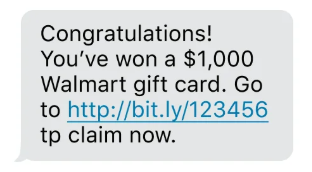

In [8]:
image_path = "./samples/02.giftcard.message.scam.png"
display(IPImage(filename=image_path))

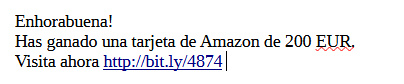

In [9]:
image_path = "./samples/scam.spanish.png"
display(IPImage(filename=image_path))

In [ ]:
# team.reset()

In [25]:
stream = team.run_stream(task=f"""does the content of the image in {image_path} represent a scam?""")

In [11]:
from autogen_agentchat.ui import Console
await Console(stream)

---------- user ----------
does the content of the image in ./samples/scam.spanish.png represent a scam?


---------- OCR_Specialist ----------
[FunctionCall(id='call_ju9AZzgXO6qVwArvaK0BykI9', arguments='{"image_path":"./samples/scam.spanish.png"}', name='ocr')]
[Prompt tokens: 116, Completion tokens: 21]
---------- OCR_Specialist ----------
[FunctionExecutionResult(content='Enhorabuena!\nHas ganado una tarjeta de Amazon de 200 EUR.\nVisita ahora http://bit.ly/4874|\n\x0c', call_id='call_ju9AZzgXO6qVwArvaK0BykI9')]
---------- OCR_Specialist ----------
Enhorabuena!
Has ganado una tarjeta de Amazon de 200 EUR.
Visita ahora http://bit.ly/4874|

---------- Content_Analyst ----------
[FunctionCall(id='call_5G9R8qhWyTbTODkzOmQOhHSA', arguments='{"target_url": "http://bit.ly/4874"}', name='is_url_safe')]
[Prompt tokens: 187, Completion tokens: 38]
---------- Content_Analyst ----------
[FunctionExecutionResult(content='(True, [])', call_id='call_5G9R8qhWyTbTODkzOmQOhHSA')]
---------- Content_Analyst ----------
(True, [])
---------- Decision_Maker ----------
The content extracted from the image yo

TaskResult(messages=[TextMessage(source='user', models_usage=None, content='does the content of the image in ./samples/scam.spanish.png represent a scam?', type='TextMessage'), ToolCallMessage(source='OCR_Specialist', models_usage=RequestUsage(prompt_tokens=116, completion_tokens=21), content=[FunctionCall(id='call_ju9AZzgXO6qVwArvaK0BykI9', arguments='{"image_path":"./samples/scam.spanish.png"}', name='ocr')], type='ToolCallMessage'), ToolCallResultMessage(source='OCR_Specialist', models_usage=None, content=[FunctionExecutionResult(content='Enhorabuena!\nHas ganado una tarjeta de Amazon de 200 EUR.\nVisita ahora http://bit.ly/4874|\n\x0c', call_id='call_ju9AZzgXO6qVwArvaK0BykI9')], type='ToolCallResultMessage'), TextMessage(source='OCR_Specialist', models_usage=None, content='Enhorabuena!\nHas ganado una tarjeta de Amazon de 200 EUR.\nVisita ahora http://bit.ly/4874|\n\x0c', type='TextMessage'), ToolCallMessage(source='Content_Analyst', models_usage=RequestUsage(prompt_tokens=187, com

In [26]:
streams = []
async for s in stream:
    streams.append(s)

In [27]:
from pprint import pprint
pprint(streams[-1].messages[-1].content)

('El mensaje de la imagen sugiere fuertemente una estafa. Anuncia un supuesto '
 'premio inesperado de una tarjeta de regalo de Amazon por 200 EUR, instando a '
 'una acción inmediata con una instrucción de "visita ahora", e incluye un '
 'enlace acortado que podría ocultar un destino malicioso. Estos elementos '
 'coinciden con las tácticas típicas de estafas diseñadas para engañar a los '
 'usuarios y lograr que hagan clic en enlaces potencialmente dañinos. Las '
 'promociones genuinas de compañías como Amazon ofrecen detalles claros y '
 'enlaces verificados. Se aconseja evitar el enlace y no proporcionar ninguna '
 'información personal. En su lugar, informa del mensaje a las autoridades o a '
 'la empresa suplantada para mayor seguridad.')
